# Not filtered to show overall trend and forecasted trend to 2050.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the file path
file_path = 'data/hurdat2_1851_2023.txt'


In [6]:
# Initialize variables
cyclone_data = []
current_cyclone = None

# Function to convert latitude and longitude to float
def convert_lat_lon(value):
    if 'N' in value or 'E' in value:
        return float(value[:-1])
    elif 'S' in value or 'W' in value:
        return -float(value[:-1])

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Check if the line starts with 'AL' indicating a new cyclone
        if line.startswith('AL'):
            if current_cyclone is not None:
                cyclone_data.append(current_cyclone)
            current_cyclone = {'header': line.strip(), 'data': []}
        else:
            if current_cyclone is not None:
                current_cyclone['data'].append(line.strip().split(','))

# Append the last cyclone
if current_cyclone is not None:
    cyclone_data.append(current_cyclone)

# Process each cyclone's data
all_cyclone_dfs = []
for cyclone in cyclone_data:
    df = pd.DataFrame(cyclone['data'], columns=['Date', 'Time', 'Record', 'Status', 'Latitude', 'Longitude', 'WindSpeed', 'Pressure',
                                                'Rad_34_NE', 'Rad_34_SE', 'Rad_34_SW', 'Rad_34_NW', 'Rad_50_NE', 'Rad_50_SE',
                                                'Rad_50_SW', 'Rad_50_NW', 'Rad_64_NE', 'Rad_64_SE', 'Rad_64_SW', 'Rad_64_NW', 'maxwnd'])
    # Convert data types where necessary
    df['Date'] = df['Date'].astype(str)
    df['Time'] = df['Time'].astype(str)
    df['Latitude'] = df['Latitude'].apply(convert_lat_lon)
    df['Longitude'] = df['Longitude'].apply(convert_lat_lon)
    df['WindSpeed'] = df['WindSpeed'].astype(int)
    df['Pressure'] = df['Pressure'].astype(int)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y%m%d %H%M')
    df.set_index('Datetime', inplace=True)
    df['Cyclone'] = cyclone['header']  # Add a column for the cyclone identifier
    all_cyclone_dfs.append(df)

# Concatenate all cyclone dataframes into a single dataframe
all_data = pd.concat(all_cyclone_dfs)

# Move the Cyclone column to the first position
columns = ['Cyclone'] + [col for col in all_data.columns if col != 'Cyclone']
all_data = all_data[columns]

# Extract the year from the Datetime column
all_data['Year'] = all_data.index.year

# Group by year and count unique cyclones
cyclones_per_year = all_data.groupby('Year')['Cyclone'].nunique()




In [8]:
# Calculate the trend line
z = np.polyfit(cyclones_per_year.index, cyclones_per_year.values, 2)
p = np.poly1d(z)

# Define the future range for forecasting
last_year = cyclones_per_year.index.max()
future_years = np.arange(last_year + 1, last_year + 27)

# Combine the historical and future years
extended_years = np.concatenate((cyclones_per_year.index, future_years))

# Calculate the trendline values for the extended range
trendline_values = p(extended_years)

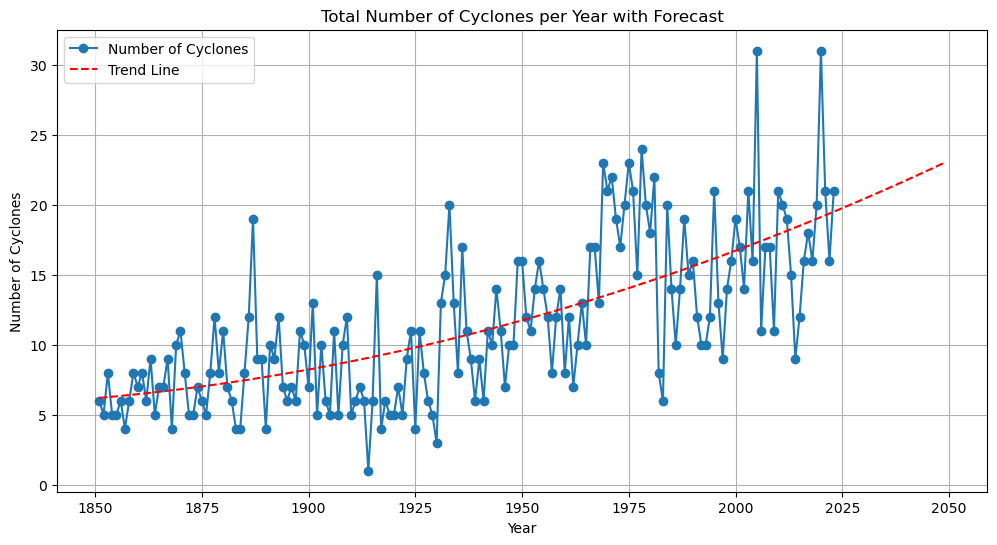

In [10]:
# Plot the total number of cyclones per year with extended trend line
plt.figure(figsize=(12, 6))
plt.plot(cyclones_per_year.index, cyclones_per_year.values, marker='o', label='Number of Cyclones')
plt.plot(extended_years, trendline_values, "r--", label='Trend Line')
plt.title('Total Number of Cyclones per Year with Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Cyclones')
plt.legend()
plt.grid(True)
plt.show()